Lets try actually training it with only the last layer unfrozen.

In [1]:
from fastai.vision import *

import pandas as pd

import torch
from torch.optim import Optimizer

from efficientnet_pytorch import EfficientNet

In [2]:
PROJECT_ROOT = Path('.').absolute().parents[0]
DATA_FOLDER = PROJECT_ROOT / 'data' / 'processed'
TRAIN_CSV = DATA_FOLDER / 'train.csv'
VALID_CSV = DATA_FOLDER / 'valid.csv'
CARS_FOLDER = DATA_FOLDER / 'car_data'

MODEL_NAME = 'efficientnet-b3'
IMAGE_SIZE = EfficientNet.get_image_size(MODEL_NAME)
BATCH_SIZE = 7

### Create the Learner

In [3]:
np.random.seed(42)
data = (
    ImageList.from_folder(CARS_FOLDER/'train')
        .split_by_rand_pct(0.1)
        .label_from_folder()
        .transform(tfms=get_transforms(), size=IMAGE_SIZE, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats)
)

In [4]:
model = EfficientNet.from_pretrained(MODEL_NAME)

Loaded pretrained weights for efficientnet-b3


In [5]:
learn = Learner(
    data,
    model,
    metrics=[accuracy]
)

In [6]:
model.add_module('_fc',nn.Linear(1536, data.c))

In [7]:
learn.layer_groups = [
    nn.Sequential(learn.layer_groups[0][:-1]),
    nn.Sequential(learn.layer_groups[0][-1])
]

In [8]:
learn.freeze()

In [11]:
learn.model.cuda() ; None

### Train the Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.10E-05


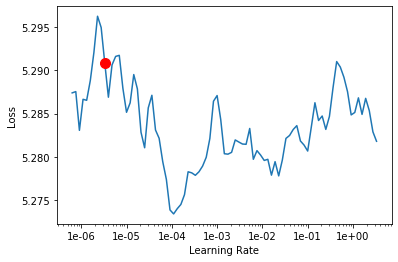

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
LEARNING_RATE = 3E-2

In [16]:
learn.fit_one_cycle(20, max_lr=LEARNING_RATE)

KeyboardInterrupt: 

In [17]:
LEARNING_RATE = 3E-4

In [18]:
learn.fit_one_cycle(20, max_lr=LEARNING_RATE)

That is a terrible accuracy. Terrible. Barely above 1%.

In the original notebook the final layer grouped the batch normalization with the linear layer.
It may be good to look at how the resnet architecture links in with the creation of the cnn, to see if I can hook into that somehow.